## Q5: Implement Kernel PCA for Logistic Regression

Datasets: 

1. Twospirals: 1000 2-dim datapoints

2. Threecircles: 1000 2-dim datapoints



In [22]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [23]:
# data loading

two_spirals = pd.read_csv('twospirals.txt', sep='\t', names=['x', 'y', 'label'])

three_circles = pd.read_csv('threecircles.txt', sep=',', names=['x', 'y', 'label'])

print(two_spirals.head())
print(three_circles.head())

         x        y  label
0  10.5192  -0.7170   -1.0
1   0.9987  -9.9681   -1.0
2   3.5763   8.3756   -1.0
3   1.9236 -10.6448   -1.0
4   8.1583  -5.9066   -1.0
          x         y  label
0 -0.208626 -0.264189     -1
1  0.499955 -0.073624     -1
2 -0.241661 -0.221071     -1
3 -0.356841  0.204201     -1
4  0.529480  0.170605     -1


In [24]:
#A) Train a linear/logistic regression model (library, logistic if data labels are categiories) and confirm that it doesnt work: high classification error or high Root MSE.

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

log_reg_model = LogisticRegressionModel(2)


In [25]:
# train / test
X = two_spirals[['x', 'y']].values
y = two_spirals['label'].values

# Convert labels from -1 and 1 to 0 and 1
y = (y + 1) / 2

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

criterion = nn.MSELoss()
optimizer = optim.SGD(log_reg_model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = log_reg_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'epoch {epoch}, loss {loss.item()}')

# test
outputs = log_reg_model(X)
print(outputs)
print(y)



epoch 0, loss 0.49041399359703064
epoch 100, loss 0.42774802446365356
epoch 200, loss 0.23134015500545502
epoch 300, loss 0.2180653065443039
epoch 400, loss 0.21712654829025269
epoch 500, loss 0.21633280813694
epoch 600, loss 0.21563756465911865
epoch 700, loss 0.21503201127052307
epoch 800, loss 0.21450746059417725
epoch 900, loss 0.21405522525310516
tensor([[0.2558],
        [0.3579],
        [0.6085],
        [0.3216],
        [0.2388],
        [0.6086],
        [0.2991],
        [0.2278],
        [0.7293],
        [0.6006],
        [0.4385],
        [0.3088],
        [0.4631],
        [0.2807],
        [0.6697],
        [0.4858],
        [0.5430],
        [0.2323],
        [0.2509],
        [0.2335],
        [0.6089],
        [0.7838],
        [0.4182],
        [0.2963],
        [0.3832],
        [0.2777],
        [0.4702],
        [0.4233],
        [0.6207],
        [0.5786],
        [0.3136],
        [0.3109],
        [0.2443],
        [0.4253],
        [0.4243],
        [0.2966]

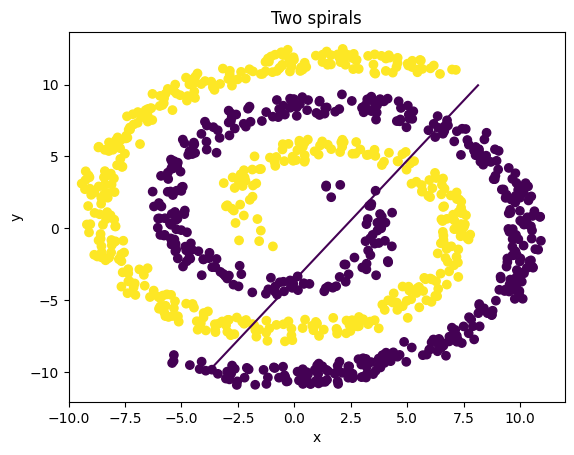

In [26]:
# visualize: plot the data points and the decision boundary
import matplotlib.pyplot as plt

plt.scatter(two_spirals['x'], two_spirals['y'], c=two_spirals['label'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Two spirals')
# plot decision boundary
x = torch.linspace(-10, 10, 100)
y = torch.linspace(-10, 10, 100)
X, Y = torch.meshgrid(x, y)
Z = torch.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = log_reg_model(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).detach()
plt.contour(X.numpy(), Y.numpy(), Z.numpy(), levels=[0.5])

plt.show()


In [27]:
# Run kernelPCA with a Gaussian Kernel to obtain a representation of T features. 
# Use the kernelPCA representation as input to a linear regression model (dualizaed form of data).

from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = two_spirals[['x', 'y']].values
y = two_spirals['label'].values

# Convert labels from -1 and 1 to 0 and 1
y = (y + 1) / 2


In [28]:
# steps demo'd in class:

#get pairwise squared euclidean distance:
x2 = np.sum(X**2, axis=1)
dist = x2[:, None] + x2[None, :] - 2 * np.dot(X, X.T)

# kernel matrix
sigma = 3
# K = np.exp(-dist / (2 * sigma**2))
K = np.exp(-dist / sigma)

# normalize kernel to correspond to zero-mean
U = np.ones(K.shape) / K.shape[0]
K = K - U @ K - K @ U + U @ K @ U

# eigenvalues and eigenvectors, sort them with largest eig first
eigvals, eigvecs = np.linalg.eigh(K)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
 

# project data to the first:
# 3 eigenvectors
X_3_kpca = eigvecs[:, :3] * np.sqrt(eigvals[:3])
# 20 eigenvectors
X_20_kpca = eigvecs[:, :20] * np.sqrt(eigvals[:20])
# 100 eigenvectors
X_100_kpca = eigvecs[:, :100] * np.sqrt(eigvals[:100])

In [29]:
# Retrain the linear regression model with the kernelPCA representation (dualized data)

X_train, X_test, y_train, y_test = train_test_split(X_3_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.20478310075606226


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_20_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.04774920184168902


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_100_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.0020450473866548743


In [37]:
# run on three circles

X = three_circles[['x', 'y']].values
y = three_circles['label'].values

# steps demo'd in class:

#get pairwise squared euclidean distance:
x2 = np.sum(X**2, axis=1)
dist = x2[:, None] + x2[None, :] - 2 * np.dot(X, X.T)

# kernel matrix
sigma = 3
# K = np.exp(-dist / (2 * sigma**2))
K = np.exp(-dist / sigma)

# normalize kernel to correspond to zero-mean
U = np.ones(K.shape) / K.shape[0]
K = K - U @ K - K @ U + U @ K @ U

# eigenvalues and eigenvectors, sort them with largest eig first
eigvals, eigvecs = np.linalg.eigh(K)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
 

# project data to the first:
# 3 eigenvectors
X_3_kpca = eigvecs[:, :3] * np.sqrt(eigvals[:3])
# 20 eigenvectors
X_20_kpca = eigvecs[:, :20] * np.sqrt(eigvals[:20])
# 100 eigenvectors
X_100_kpca = eigvecs[:, :100] * np.sqrt(eigvals[:100])

In [38]:
# Retrain the linear regression model with the kernelPCA representation (dualized data)

X_train, X_test, y_train, y_test = train_test_split(X_3_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.03275907015695505


In [39]:
# Retrain the linear regression model with the kernelPCA representation (dualized data)

X_train, X_test, y_train, y_test = train_test_split(X_20_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.005708561408848931


In [40]:
# Retrain the linear regression model with the kernelPCA representation (dualized data)

X_train, X_test, y_train, y_test = train_test_split(X_100_kpca, y, test_size=0.2)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_pred = lin_reg_model.predict(X_test)
print(mean_squared_error(y_test, y_pred))


0.0006339029034518937
